# Thermal de-swelling of a sphere

- Swelling-deswelling-reswelling of a sphere
- This is a three-dimensional simulation

# Degrees of freedom
- Displacement: u
- pressure: p
- chemical potential: mu
- concentration: c
- temperature: theta

# Units
- Length: mm
- Mass: tonne (1000kg)
- Time: s
- Mass density: tonne/mm^3
- Force: N
- Stress: MPa
- Energy: mJ
- Temperature: K
- Amount of substance: mol
- Species concentration: mol/mm^3
- Chemical potential: mJ/mol
- Molar volume: mm^3/mol
- Species diffusivity: mm^2/s
- Thermal expansion coefficient: #/K
- Specific heat: mJ/(mm^3 K)
- Thermal conductivity: mW/(mm K)
- Boltzmann Constant: 1.38E-20 mJ/K
- Gas constant: 8.3145E3 mJ/(mol K)

### Software:
- Dolfinx v0.8.0

Eric Stewart and Lallit Anand  

ericstew@mit.edu and anand@mit.edu   

June 2024

# Import modules

In [28]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [29]:
# Create square mesh 
R0 = 2.5  # mm,  radius of sphere

# Read in the 3D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/sphere_v3.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 2D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/facet_sphere_v3.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")

x = ufl.SpatialCoordinate(domain)

**Print out unique cell number indices**

In [31]:
top_imap = domain.topology.index_map(2)      # index map of 3D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 3D entities
values[cell_tags.indices]=cell_tags.values   # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))           # printing the unique indices

[12]


**Print out the unique facet index numbers**

In [32]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

# # Surface and volume  labels form Gmsh
# Physical Surface("yBot", 8) 
# //+
# Physical Surface("zBot", 9)  
# //+
# Physical Surface("xBot", 10) 
# //+
# Physical Surface("Outer", 11) 
# //+
# Physical Volume("totVol", 12) 

[ 8  9 10 11]


**Visualize the reference configuration**

In [33]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter.add_mesh(grid, show_edges=True)    #, opacity=0.25) 

# # Surface and volume  labels form Gmsh
# Physical Surface("yBot", 8) 
# //+
# Physical Surface("zBot", 9) 
# //+
# Physical Surface("xBot", 10) 
# //+
# Physical Surface("Outer", 11) 
# //+
# Physical Volume("totVol", 12) 

# Add colored 2D surfaces for the named surfaces
ybot= pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==8]) )
zbot = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==9]) )
xbot = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==10]) )
outer_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim-1,facet_tags.indices[facet_tags.values==11]) )
#
actor  = plotter.add_mesh(ybot,      show_edges=True,color="blue")  
actor2 = plotter.add_mesh(zbot,      show_edges=True,color="red")  
actor3 = plotter.add_mesh(xbot,      show_edges=True,color="green")  
actor3 = plotter.add_mesh(outer_surf,show_edges=True,color="magenta") 

labels = dict(xlabel='X', ylabel='Y',zlabel='Z')
plotter.add_axes(**labels)

# plotter.screenshot("results/sphere_mesh.png")

# from IPython.display import Image
# Image(filename='results/sphere_mesh.png') 

#Use the following  commands for a  zoom-able  view
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot("sphere_mesh.png")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

## Define boundary and volume integration measure

In [34]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

#  Define facet normal
n = ufl.FacetNormal(domain)

# Material parmeters

In [35]:
# Set the locking stretch to a large number to model a Neo-Hookean material
#
k_B      = Constant(domain,PETSc.ScalarType(1.38E-20))              # Boltzmann's constant
R_gas    = Constant(domain,PETSc.ScalarType(8.3145E3))              # Gas constant
theta0   = Constant(domain,PETSc.ScalarType(298))                   # Initial temperature
Gshear_0 = Constant(domain,PETSc.ScalarType(0.3))                   # Ground sate shear modulus
N_R      = Constant(domain,PETSc.ScalarType(Gshear_0/(k_B*theta0))) # Number polymer chains per unit ref. volume
lambdaL  = Constant(domain,PETSc.ScalarType(5.2))                   # Locking stretch
Kbulk    = Constant(domain,PETSc.ScalarType(1000.0*Gshear_0))       # Bulk modulus
#
Omega    = Constant(domain,PETSc.ScalarType(1.0E5))                 # Molar volume of fluid
D        = Constant(domain,PETSc.ScalarType(5.0E-3))                # Diffusivity
chi_L    = Constant(domain,PETSc.ScalarType(0.1))                   # Flory-Huggins mixing parameter low value
chi_H    = Constant(domain,PETSc.ScalarType(0.7))                   # Flory-Huggins mixing parameter high value
theta_T  = Constant(domain,PETSc.ScalarType(307))                   # Transition temperature
Delta_T  = Constant(domain,PETSc.ScalarType(5.0))                   # Transition temperature width
alpha    = Constant(domain,PETSc.ScalarType(70.0E-6))               # Coefficient of thermal expansion
c_v      = Constant(domain,PETSc.ScalarType(4.18))                  # Specific heat
k_therm  = Constant(domain,PETSc.ScalarType(0.53))                  # Thermal conductivity
#
phi0    = Constant(domain,PETSc.ScalarType(0.999))                # Initial polymer volume fraction
mu0     = Constant(domain,PETSc.ScalarType(ln(1.0-phi0) + phi0 )) # Initial chemical potential
c0      = Constant(domain,PETSc.ScalarType((1/phi0) - 1))         # Initial concentration

# Simulation time-control related parameters

In [36]:
t          = 0.0        # initialization of time
ttd        = 500        # time for increasing mu
tRamp      = 3600*2     # time to increase or decrease tempearture

time1      = 3600*2   
# 
time2      = 3600*4      
#
time3      = 3600*5    
#
time4      = 3600*7 
#
time5      = 3600*8    
#
Ttot       = time5 

# Constant time step  
dt   =  100   

# Time step field, constant within body
dk = Constant(domain, PETSc.ScalarType(dt))


# Function spaces

In [37]:
# Define function space, both vectorial and scalar
# 
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(3,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1) # For pressure, chemical potential,
                                                 # species concentration, and temperature
#                                      
TH = mixed_element([U2, P1, P1, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)            # Total space for all DOFs

# Define actual functions with the required DOFs
w = Function(ME)
u, p, mu, c, theta = split(w)  # displacement u, pressure p, chemical potential mu,
                               # concentration c, and temperature theta

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
u_old,  p_old, mu_old, c_old, theta_old = split(w_old)   

# Define test functions    
u_test, p_test,  mu_test, c_test, theta_test = TestFunctions(ME)  

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                  

# Assign initial  normalized chemical potential  mu0 to the domain
w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  mu0))
w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],), mu0))  

# Assign initial  value of normalized concentration  c0 to the domain
w.sub(3).interpolate(lambda x: np.full((x.shape[1],),  c0))
w_old.sub(3).interpolate(lambda x: np.full((x.shape[1],), c0))     

# Assign initial  value of tempearture  theta0 to the domain
w.sub(4).interpolate(lambda x: np.full((x.shape[1],),  theta0))
w_old.sub(4).interpolate(lambda x: np.full((x.shape[1],), theta0))     

# Subroutines for kinematics and constitutive equations

In [38]:
# Deformation gradient 
def F_calc(u):
    
    Id = Identity(3)          # 3D Identity tensor
    
    F = Id + grad(u)            # 3D Deformation gradient
    
    return F

#  Elastic deformation gradient Fe
def Fe_calc(u,c):
    F = F_calc(u)      
    J = det(F)             
    #
    Js = 1.0 + c          
    Fs = Js**(1/3)*Identity(3) 
    #
    Fe = F*inv(Fs)
    return   Fe   

def lambdaBar_calc(u):
    F = F_calc(u)
    C = F.T*F
    I1 = tr(C)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

# Calculate zeta
def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

# Calculate zeta0
def zeta0_calc():
    # Use Pade approximation of Langevin inverse (A. Cohen, 1991)
    z    = 1/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep from blowing up
    beta0 = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta0 = (lambdaL/3)*beta0
    return zeta0

# chi-parameter
def chi_calc(theta):
     chi = 0.5*(chi_L + chi_H)- 0.5*(chi_L - chi_H)* tanh((theta-theta_T)/Delta_T)
     return chi
 
# Stress-temperature modulus
def MH1_calc(u,c):
    Id = Identity(3)
    Fe = Fe_calc(u,c)
    Je = det(Fe)
    Ce = Fe.T*Fe
    Js = 1 + c
    zeta = zeta_calc(u)
    zeta0 = zeta0_calc()
    fac1 = N_R * k_B * ( zeta * Js**(2/3) * Id - zeta0 * inv(Ce) )
    fac2 = (3*Kbulk*alpha/Je) * inv(Ce)
    MH1 = 0.5*(fac1 +fac2)
    return MH1

# Chemical potential-temperature modulus
def MH2_calc(u,c):
    Id = Identity(3)
    F = F_calc(u)
    C = F.T*F
    Js = 1 + c
    zeta  = zeta_calc(u)
    zeta0 = zeta0_calc()
    chi   = chi_calc(theta)
    #
    fac1 = R_gas*( ln(c/Js) + 1/Js + chi/Js**2 )
    fac2 = (Omega*N_R*k_B/Js)*( zeta*tr(C)/3 - zeta0 )
    MH2 = fac1+ fac2
    return MH2

# Normalized Piola stress 
def Piola_calc(u, p, theta):
    F = F_calc(u)
    #
    J = det(F)
    #
    zeta = zeta_calc(u)
    #
    zeta0 = zeta0_calc()
    #
    Gshear0  = N_R * k_B * theta
    #
    Piola = (zeta*F - zeta0*inv(F.T) ) - (J * p/Gshear0) * inv(F.T) 
    return Piola

# Species flux
def Flux_calc(u, mu, c, theta):
    F = F_calc(u) 
    #
    Cinv = inv(F.T*F) 
    #
    RT = R_gas * theta
    #
    Mob = (D*c)/(Omega*RT)*Cinv # Mobility tensor
    #
    Jmat = - RT* Mob * grad(mu)
    return Jmat

#  Heat flux
def Heat_flux_calc(u, theta):
    F  = F_calc(u) 
    J = det(F)         
    #
    Cinv = inv(F.T*F) 
    #
    Tcond = J * k_therm * Cinv # Thermal conductivity tensor
    #
    Qmat = - Tcond * grad(theta)
    return Qmat

# Evaluate kinematics and constitutive relations

In [39]:
# Kinematics
F = F_calc(u)
J = det(F)  

# lambdaBar
lambdaBar = lambdaBar_calc(u)

# Fe 
Fe     = Fe_calc(u,c)                    
Fe_old = Fe_calc(u_old,c_old)

# Je
Je = det(Fe)

# Ce
Ce = Fe.T * Fe
Ce_old = Fe_old.T * Fe_old

#  Piola stress
Piola = Piola_calc(u, p, theta)

# Species flux
Jmat = Flux_calc(u, mu, c, theta)

# Heat flux
Qmat = Heat_flux_calc(u, theta)

# Heat-coupling terms
MH1 = MH1_calc(u,c)
MH2 = MH2_calc(u,c)

# RT
RT      = R_gas*theta

# chi-parameter
chi = chi_calc(theta)

# Weak forms

In [40]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Pressure (test fxn: p)
# Res_2: Balance of mass   (test fxn: mu)
# Res_3: Concentration     (test fxn:c)
# Res_4: Tempearture       (test fxn:theta)

# The weak form for the equilibrium equation
Res_0 = inner(Piola , grad(u_test) )*dx

# The weak form for the  pressure
fac_p =   (ln(Je) - 3*alpha*(theta-theta0))
#
Res_1 = dot((p*Je/Kbulk + fac_p) , p_test)*dx
      
      
# The weak form for the mass balance of solvent      
Res_2 = dot((c - c_old)/dk, mu_test)*dx \
        -  Omega*dot(Jmat , grad(mu_test) )*dx   
        

# The weak form for the concentration
fac = 1/(1+c)
#
fac1 =  mu - ( ln(1.0-fac)+ fac + chi*fac*fac )
#
fac2 = -(Omega*Je/RT)*p  
#
fac3 = - (Omega/RT)* ((1/2) * ((Je*p)**2.0)/Kbulk - 3*Kbulk*alpha*(theta-theta0)*ln(Je))
#
fac4 = fac1 + fac2   + fac3
#
Res_3 = dot(fac4, c_test)*dx


# The weak form for the the heat equation
tfac1 = theta * inner(MH1, (Ce-Ce_old))
tfac2 = theta * MH2*(c - c_old)/Omega
tfac3 = dk * RT * inner(Jmat, grad(mu))
tfac4 = tfac1 + tfac2 - tfac3
#
Res_4 = dot( c_v*(theta - theta_old), theta_test)*dx \
        -  dk* dot(Qmat , grad(theta_test) )*dx   \
        -   dot(tfac4, theta_test)*dx
        
# Total weak form
Res = Res_0 + Res_1 + Res_2 + Res_3 + Res_4

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [41]:
# Results file name
results_name = "thermogel_sphere_swell"

# Function space for projection of results
U1 = element("DG", domain.basix_cell(), 1, shape=(3,))  # For displacement
P0 = element("DG", domain.basix_cell(), 1)              # For  pressure, chemical potential, and concentration 
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) # For stress tensor

V1 = fem.functionspace(domain, P0) # Scalar function space
V2 = fem.functionspace(domain, U1) # Vector function space
V3 = fem.functionspace(domain, T1) # Tensor function space

# basic fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

mu_vis = Function(V1)
mu_vis.name = "mu"

c_vis = Function(V1)
c_vis.name = "c"

theta_vis = Function(V1)
theta_vis.name = "theta"

# computed fields to write to output file
phi = 1/(1+c)
phi_vis = Function(V1)
phi_vis.name = "phi"
phi_expr = Expression(phi,V1.element.interpolation_points())

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())

lambdaBar_vis = Function(V1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Piola[0,0],V1.element.interpolation_points())
#
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Piola[1,1],V1.element.interpolation_points())
#
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Piola[2,2],V1.element.interpolation_points())

# Mises stress
T   = Piola*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())

# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, mu_vis, c_vis, theta_vis, phi_vis, J_vis, P11, P22, P33, 
        lambdaBar_vis,Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       
       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       mu_vis.interpolate(w.sub(2))
       c_vis.interpolate(w.sub(3))
       theta_vis.interpolate(w.sub(4))
       phi_vis.interpolate(phi_expr)
       J_vis.interpolate(J_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       lambdaBar_vis.interpolate(lambdaBar_expr)
       Mises_vis.interpolate(Mises_expr)

       # Write output fields
       file_results.write(t) 
        

# Infrastructure for pulling out time history data (displacement, force, etc.)

In [42]:
# Identify point for reporting displacement
pointForDisp = np.array([R0,0.0,0.0])

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDisp)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp).array


# Analysis Step 

In [16]:
# Give the step a descriptive name
step = "Swell-deswell-reswell"

## Boundary conditions

In [17]:
# t          = 0.0        # initialization of time
# ttd        = 500        # time for increasing mu
# tRamp      = 3600*2     # time to increase or decrease tempearture

# time1      = 3600*2   
# # 
# time2      = 3600*4      
# #
# time3      = 3600*5    
# #
# time4      = 3600*7 
# #
# time5      = 3600*8    
# #
# Ttot       = time5 


# Boundary chemical potential history:
#
def muRamp(t):
    return mu0*exp(-t/ttd)

# Constant for chemical potential history
#
mu_cons = Constant(domain,PETSc.ScalarType(muRamp(0)))


# Boundary temperature history:
#
# Temperature increase deltaTheta =25K
#
deltaTheta = Constant(domain,PETSc.ScalarType(25))
# 
def thetaRamp(t):
    if t<= time1:
       temperature = theta0  
       
    elif time1 < t <= time2:
       temperature = theta0 + deltaTheta*(t-time1)/tRamp  
        
    elif time2 < t <= time3:
        temperature = (theta0 + deltaTheta)  
        
    elif time3 < t <= time4 :
        temperature = (theta0 + deltaTheta) - deltaTheta*(t-time3)/tRamp  
         
    else:
        temperature = theta0
        
    return temperature

# Constant for temperature history
theta_cons = Constant(domain,PETSc.ScalarType(thetaRamp(0)))

# # Surface and volume  labels form Gmsh
# Physical Surface("yBot", 8) 
# //+
# Physical Surface("zBot", 9) 
# //+
# Physical Surface("xBot", 10) 
# //+
# Physical Surface("Outer", 11) 

# Find the specific DOFs which will be constrained.
xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(10))
#
yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(8))
#
zBot_u3_dofs = fem.locate_dofs_topological(ME.sub(0).sub(2), facet_tags.dim, facet_tags.find(9))
#
outer_mu_dofs = fem.locate_dofs_topological(ME.sub(2),       facet_tags.dim, facet_tags.find(11))
#
outer_theta_dofs = fem.locate_dofs_topological(ME.sub(4),    facet_tags.dim, facet_tags.find(11))


# Dirichlet BCs for displacement
bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0))    # u1 fix - xBot
bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1))    # u2 fix - yBot
bcs_3 = dirichletbc(0.0, zBot_u3_dofs, ME.sub(0).sub(2))    # u3 fix - zBot

# Dirichlet BCs for chemical potential
bcs_4 = dirichletbc(mu_cons, outer_mu_dofs, ME.sub(2))      # mu_cons - outer

# Dirichlet BCs for temperature
bcs_5 = dirichletbc(theta_cons, outer_theta_dofs, ME.sub(4))      # theta_cons - outer

bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5]


## Define the nonlinear variational problem

In [43]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# The global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"  
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize arrays for storing output history

In [44]:
# Arrays for storing output history
totSteps = 100000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps]) 
# timeHist3 = np.zeros(shape=[totSteps])
# #
timeHist2[0] = theta0 # Initialize the temperature

# Initialize a counter for reporting data
ii = 0

# Write initial state to file
writeResults(t=0.0) 


##  Start calculation loop

In [20]:
print("------------------------------------")
print("Simulation start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    mu_cons.value    = float(muRamp(t))
    theta_cons.value = float(thetaRamp(t))
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Store  displacement at a particular point  at this time
    #
    timeHist0[ii] = t                                                        # time
    #
    timeHist1[ii] = w.sub(0).sub(0).eval([R0,0.0,0.0],colliding_cells[0])[0] # displacement of outer radius
       #
    timeHist2[ii] = w.sub(4).eval([R0,0.0,0.0],colliding_cells[0])[0] # temperature of outer radius
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
    
   
    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print()  
    
# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation start
------------------------------------
Step: Swell-deswell-reswell | Increment: 1, Iterations: 6
      Simulation Time: 100.0 s  of  28800 s

Step: Swell-deswell-reswell | Increment: 2, Iterations: 6
      Simulation Time: 200.0 s  of  28800 s

Step: Swell-deswell-reswell | Increment: 3, Iterations: 5
      Simulation Time: 300.0 s  of  28800 s

Step: Swell-deswell-reswell | Increment: 4, Iterations: 5
      Simulation Time: 400.0 s  of  28800 s

Step: Swell-deswell-reswell | Increment: 5, Iterations: 5
      Simulation Time: 500.0 s  of  28800 s

Step: Swell-deswell-reswell | Increment: 6, Iterations: 5
      Simulation Time: 600.0 s  of  28800 s

Step: Swell-deswell-reswell | Increment: 7, Iterations: 5
      Simulation Time: 700.0 s  of  28800 s

Step: Swell-deswell-reswell | Increment: 8, Iterations: 5
      Simulation Time: 800.0 s  of  28800 s

Step: Swell-deswell-reswell | Increment: 9, Iterations: 5
      Simulation Time: 900.

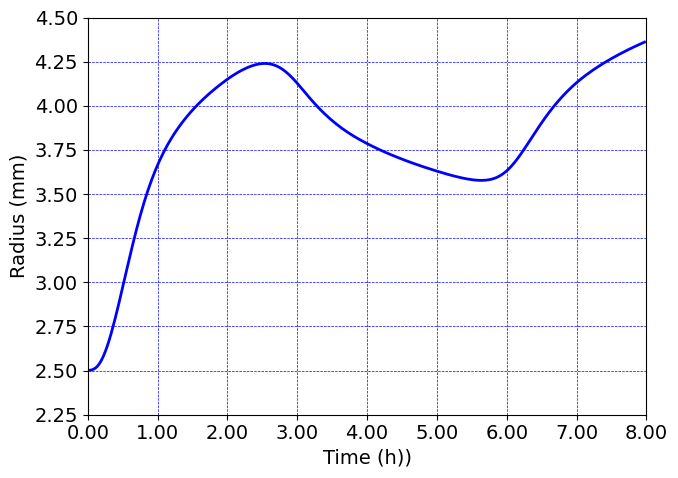

In [27]:
# Set up font size, initialize colors array
font = {'size'   : 14}
plt.rc('font', **font)
#
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0[:])

# Create figure for temperature versus  tip-displacement curve.
#
fig = plt.figure() 
ax=fig.gca()  
#---------------------------------------------------------------------------------------------
plt.plot(timeHist0[0:ind]/3600, timeHist1[0:ind]+R0, c='b', linewidth=2.0)
#---------------------------------------------------------------------------------------------
plt.xlim(0,8)
plt.ylim(2.25,4.5)
#
plt.grid(linestyle="--", linewidth=0.5, color='b')
# ax.set_ylabel("Surface temperature change, K",size=14)
ax.set_xlabel("Time (h))",size=14)
ax.set_ylabel(r'Radius (mm)',size=14)
#ax.set_title(r'Temperature versus tip displacement curve', size=14, weight='normal')
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
# ax.xaxis.set_minor_locator(AutoMinorLocator())
# ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.legend()
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
# Save figure
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/thermogel_sphere_fig1.png", dpi=600) 

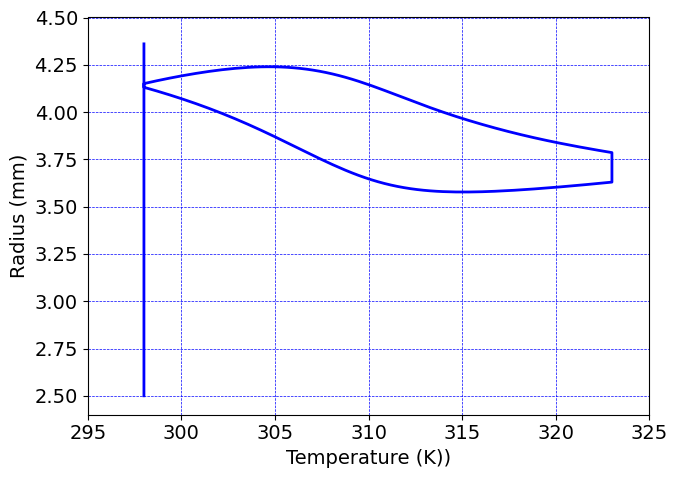

In [25]:
# Set up font size, initialize colors array
font = {'size'   : 14}
plt.rc('font', **font)
#
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0[:])

# Create figure for temperature versus  tip-displacement curve.
#
fig = plt.figure() 
ax=fig.gca()  
#---------------------------------------------------------------------------------------------
#plt.plot(timeHist2[0:ind], R0+timeHist1[0:ind], c='b', linewidth=2.0)
plt.plot(timeHist2[0:ind],  timeHist1[0:ind]+R0, c='b', linewidth=2.0)
#---------------------------------------------------------------------------------------------
plt.xlim(295,325)
plt.ylim(2.4,4.5)
#
plt.grid(linestyle="--", linewidth=0.5, color='b')
# ax.set_ylabel("Surface temperature change, K",size=14)
ax.set_xlabel("Temperature (K))",size=14)
ax.set_ylabel(r'Radius (mm)',size=14)
#ax.set_title(r'Temperature versus tip displacement curve', size=14, weight='normal')
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
# ax.xaxis.set_minor_locator(AutoMinorLocator())
# ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.legend()
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
# Save figure
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/thermogel_sphere_fig2.png", dpi=600) 